In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# Load and view dataset

In [2]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('/kaggle/input/air-pollution-data/pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.columns

/tmp/ipykernel_42/1970690838.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataset = pd.read_csv('/kaggle/input/air-pollution-data/pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)


Index(['No', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir'], dtype='object')

In [3]:
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
#dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [4]:
dataset.shape

(43800, 8)

In [5]:
dataset.columns

Index(['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow',
       'rain'],
      dtype='object')

In [6]:
dataset.isnull().sum()

pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  43800 non-null  float64
 1   dew        43800 non-null  int64  
 2   temp       43800 non-null  float64
 3   press      43800 non-null  float64
 4   wnd_dir    43800 non-null  object 
 5   wnd_spd    43800 non-null  float64
 6   snow       43800 non-null  int64  
 7   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


In [8]:
dataset.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


# Data visuvalization

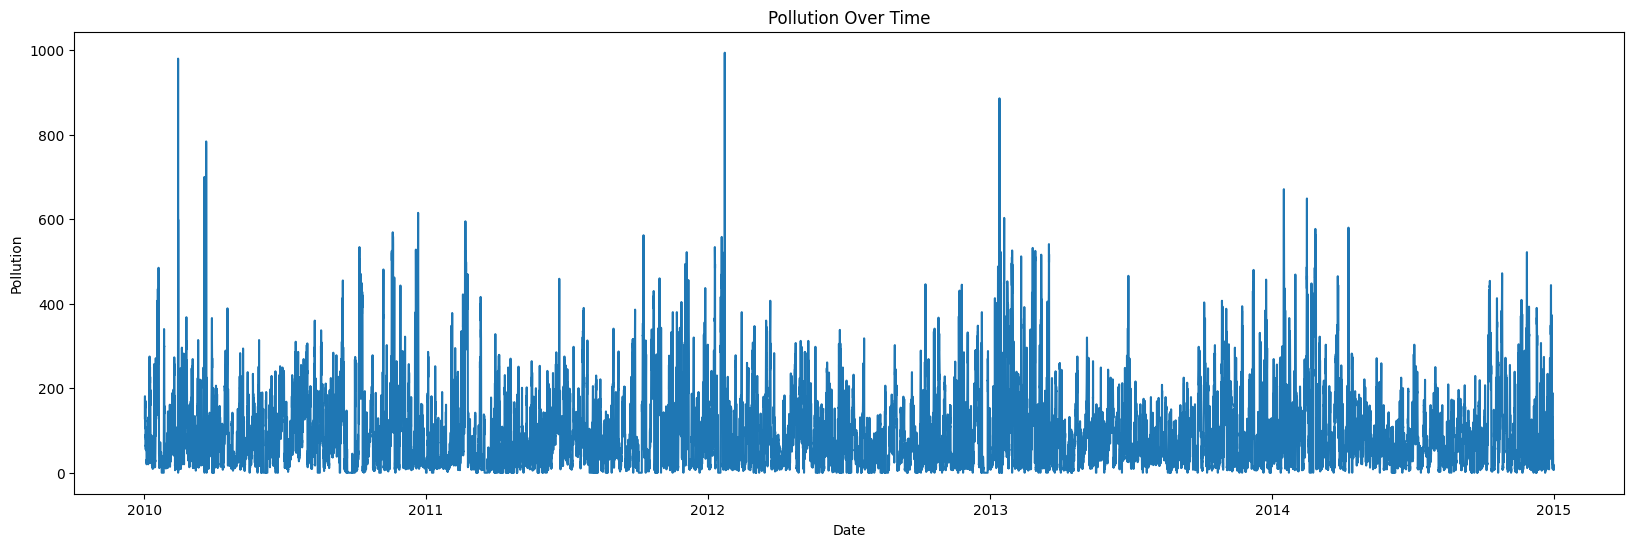

In [9]:
# Time Series Plot
plt.figure(figsize=(20, 6))
plt.plot(dataset.index, dataset['pollution'])
plt.title('Pollution Over Time')
plt.xlabel('Date')
plt.ylabel('Pollution')
plt.show()


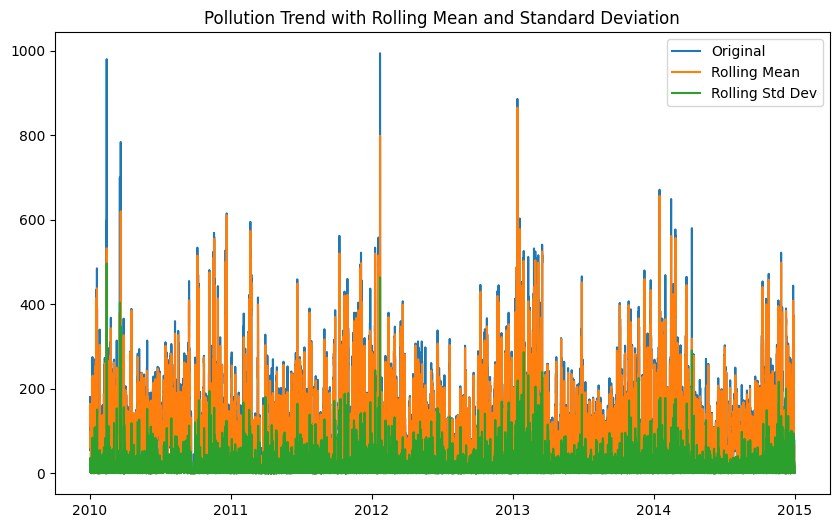

In [10]:
# Line Plots with Rolling Mean and Standard Deviation
# The rolling mean line can indicate the direction in which the data is moving over time.
# The rolling standard deviation line can indicate how consistent this movement is, or whether there are periods of unexpected variability.

rolling_window = 3  # Define the rolling window
plt.figure(figsize=(10, 6))
plt.plot(dataset['pollution'], label='Original')
plt.plot(dataset['pollution'].rolling(rolling_window).mean(), label='Rolling Mean')
plt.plot(dataset['pollution'].rolling(rolling_window).std(), label='Rolling Std Dev')
plt.title('Pollution Trend with Rolling Mean and Standard Deviation')
plt.legend()
plt.show()

This series of histograms will help in understanding the distribution of each variable in your dataset, such as how spread out the data points are, whether the data is skewed, and if there are any outliers. The addition of the KDE plots provides a smooth curve representing the density distribution, which can be helpful in identifying the shape of the data distribution

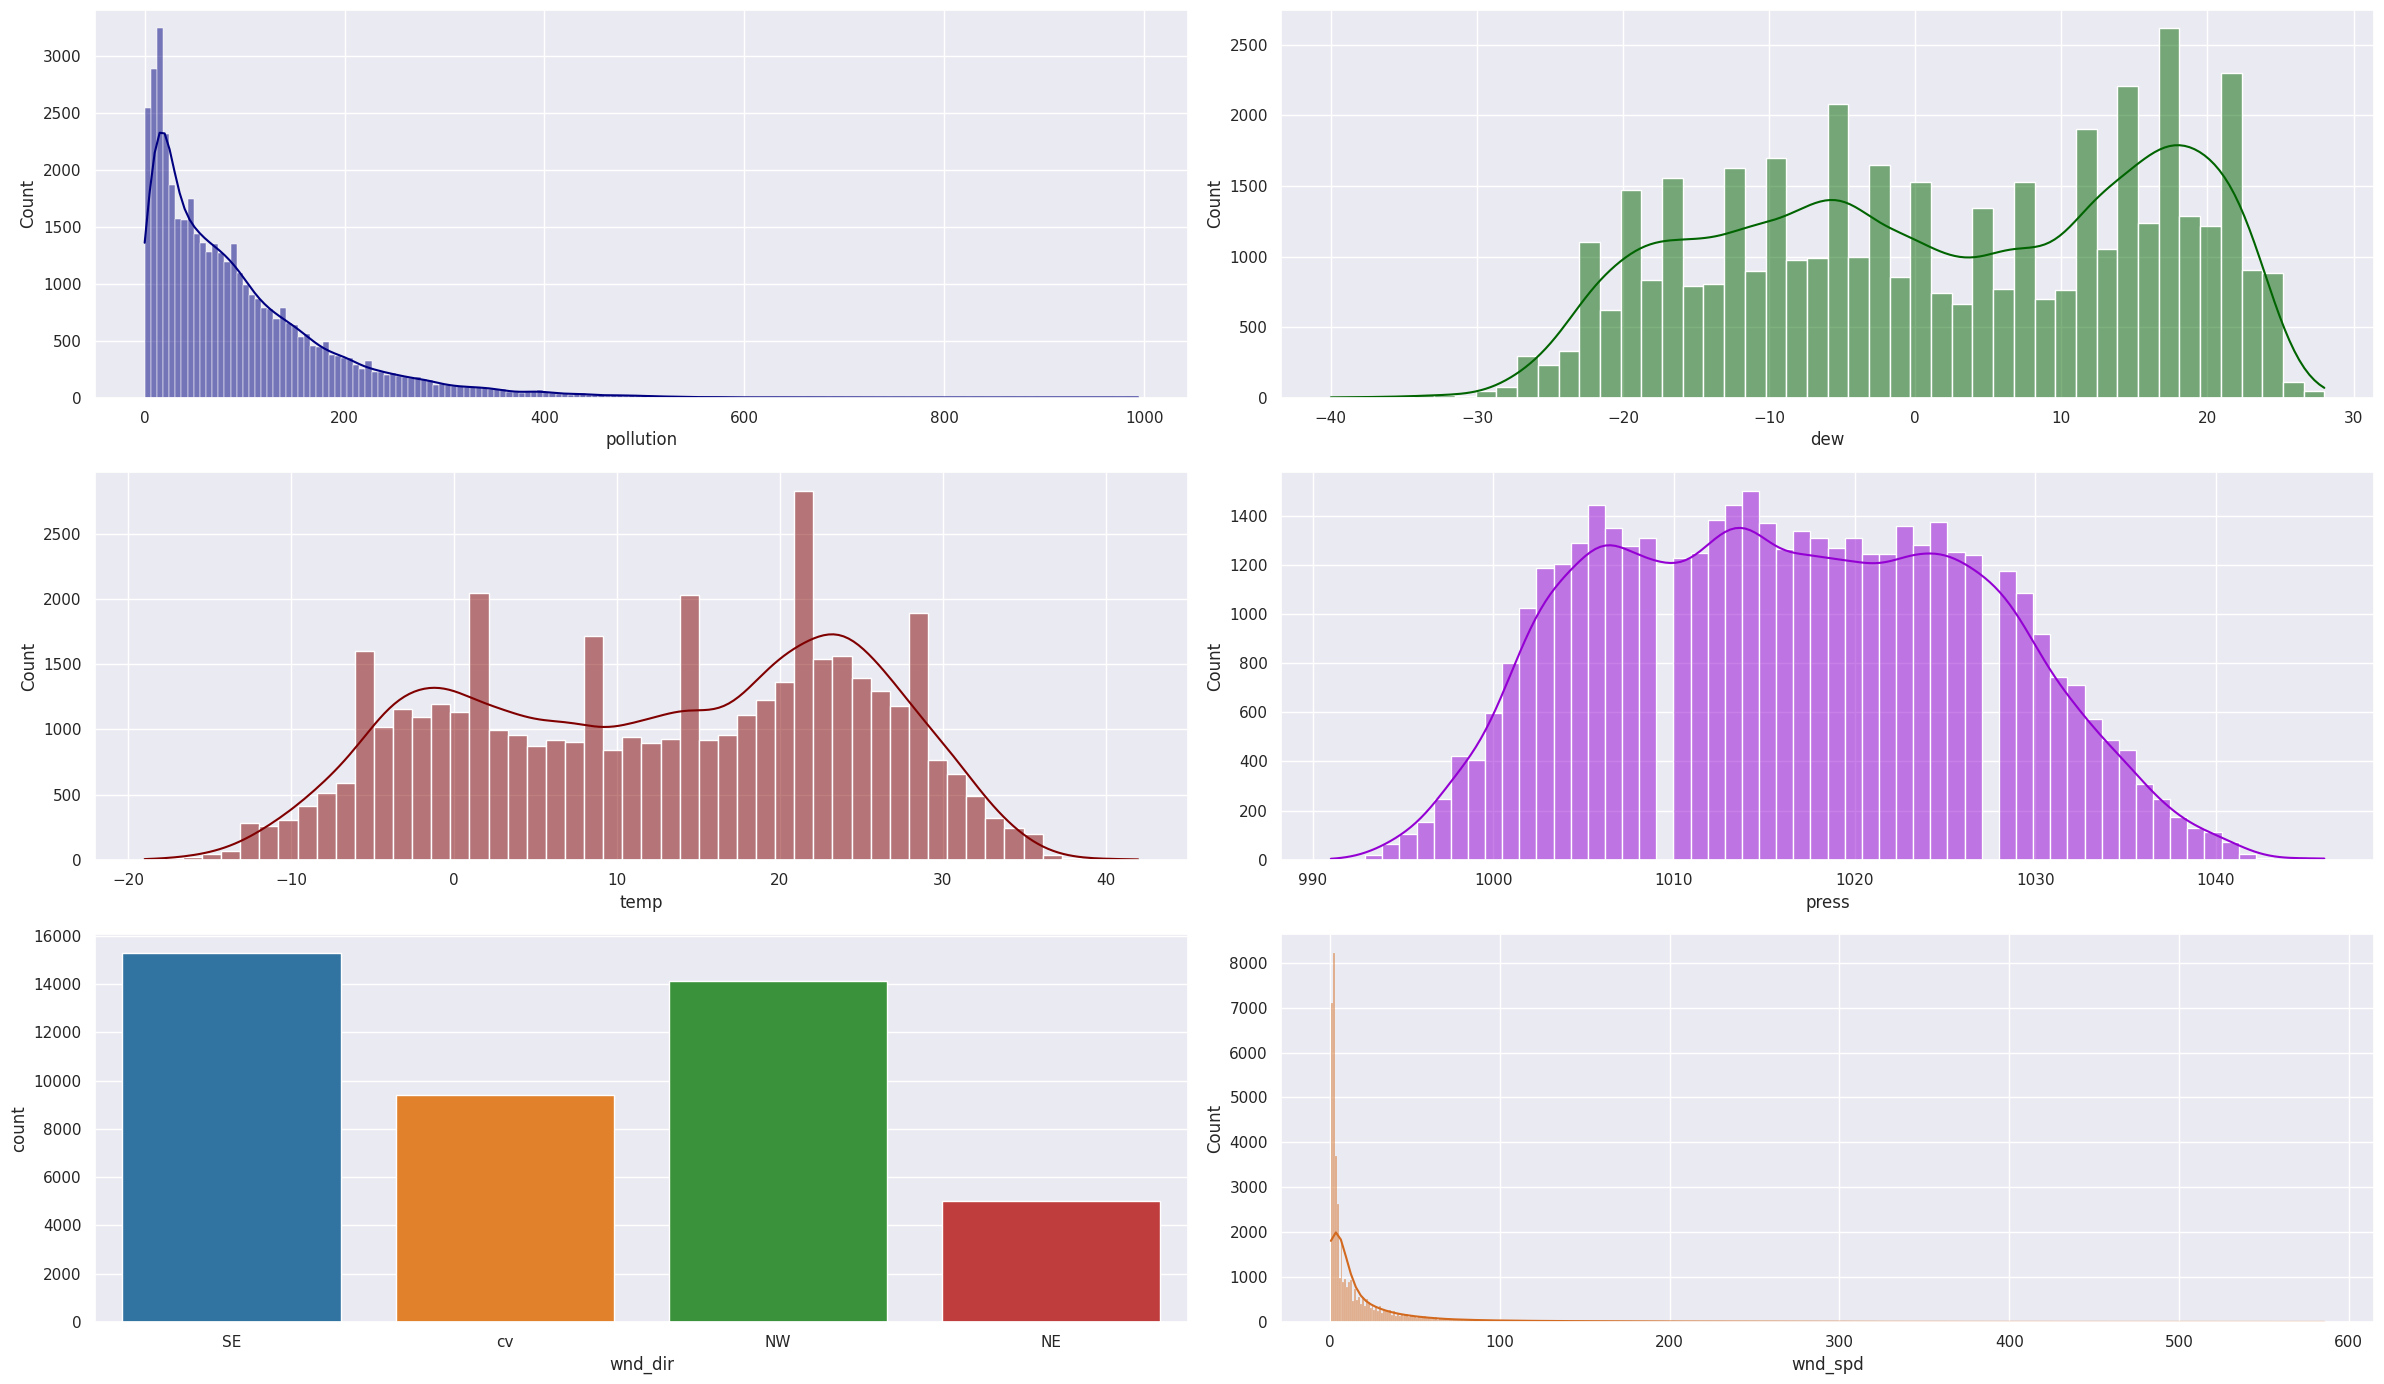

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'dataset' is your DataFrame

sns.set(style="darkgrid")

fig, axs = plt.subplots(3, 2, figsize=(24, 14))

sns.histplot(data=dataset, x="pollution", kde=True, color="navy", ax=axs[0, 0])
sns.histplot(data=dataset, x="dew", kde=True, color="darkgreen", ax=axs[0, 1])
sns.histplot(data=dataset, x="temp", kde=True, color="maroon", ax=axs[1, 0])
sns.histplot(data=dataset, x="press", kde=True, color="darkviolet", ax=axs[1, 1])
sns.countplot(data=dataset, x="wnd_dir", palette="tab10", ax=axs[2, 0])
sns.histplot(data=dataset, x="wnd_spd", kde=True, color="chocolate", ax=axs[2, 1])

plt.tight_layout()  # Adjust the layout
plt.show()


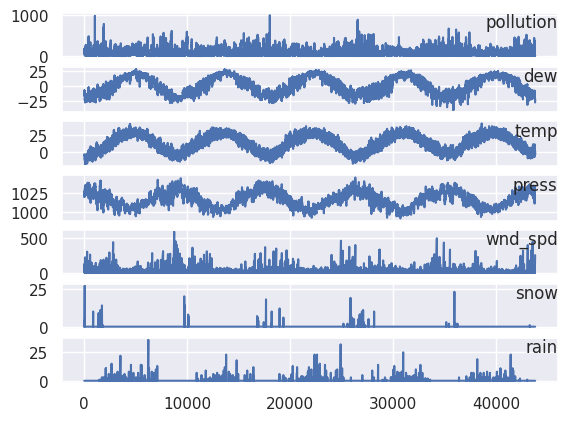

In [12]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

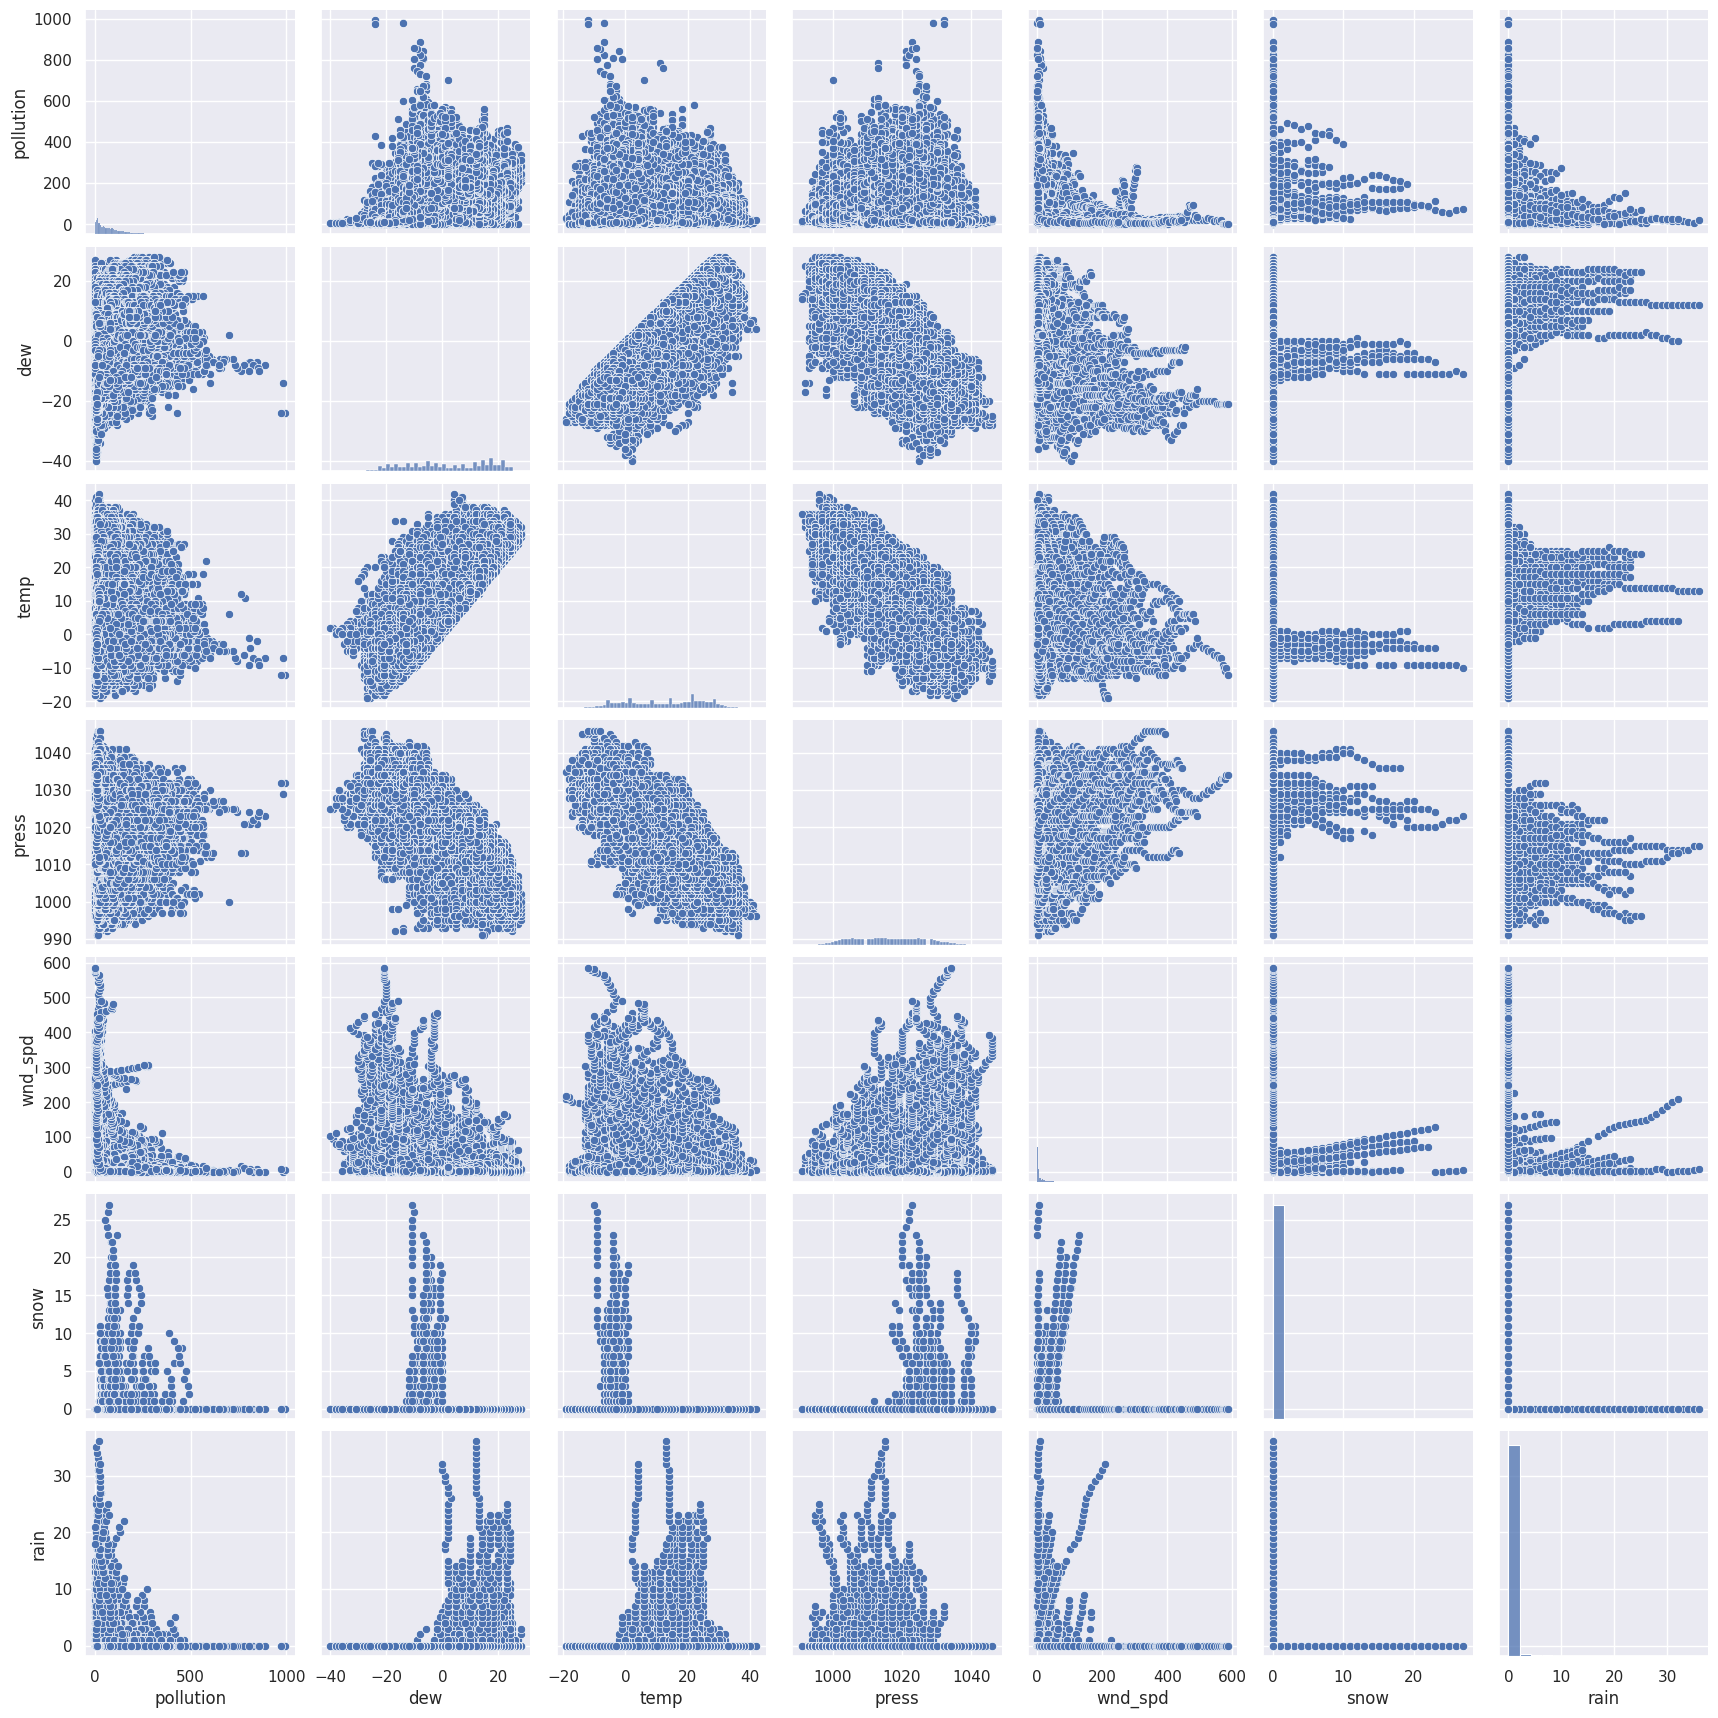

In [13]:
import seaborn as sns
sns.pairplot(data=dataset)

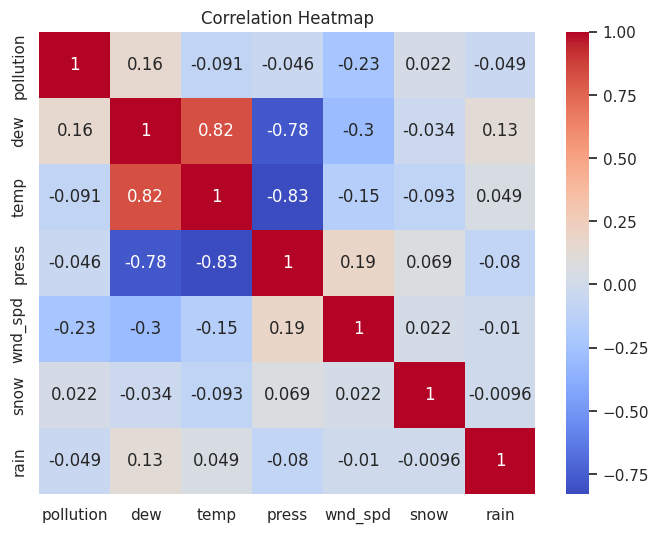

In [14]:
# Heatmap for Correlation Analysis
numeric_dataset = dataset.select_dtypes(include=[np.number]) # selecting only Numeric numbers

plt.figure(figsize=(8, 6))
sns.heatmap(numeric_dataset.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

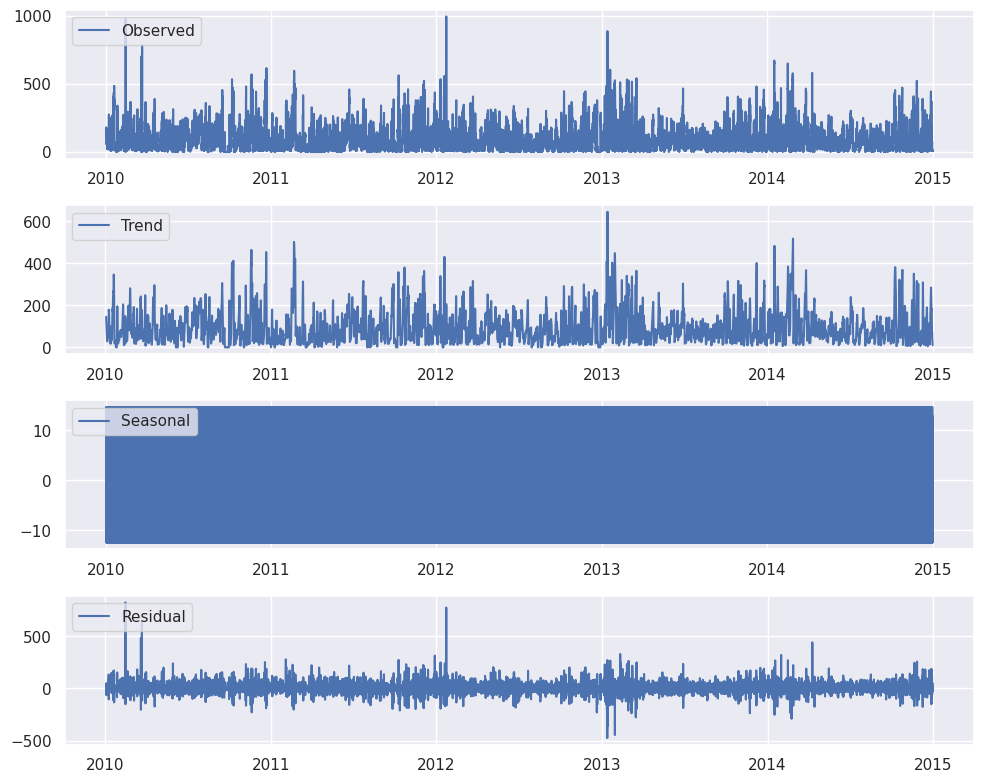

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Time Series Decomposition Plot
decomposition = seasonal_decompose(dataset['pollution'], model='additive', period=24) # Adjust 'period' as needed
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#### Multivariate LSTM Forecast Model
In this section, we will fit an LSTM to the problem.

LSTM Data Preparation
The first step is to prepare the pollution dataset for the LSTM.

This involves framing the dataset as a supervised learning problem and normalizing the input variables.

We will frame the supervised learning problem as predicting the pollution at the current hour (t) given the pollution measurement and weather conditions at the prior time step.

This formulation is straightforward and just for this demonstration. Some alternate formulations you could explore include:

* Predict the pollution for the next hour based on the weather conditions and pollution over the last 24 hours.
* Predict the pollution for the next hour as above and given the “expected” weather conditions for the next hour.

We can transform the dataset using the series_to_supervised() function

In [16]:
# prepare data for lstm
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [17]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


### Define and Fit Model
In this section, we will fit an LSTM on the multivariate input data.

First, we must split the prepared dataset into train and test sets. To speed up the training of the model for this demonstration, we will only fit the model on the first year of data, then evaluate it on the remaining 4 years of data. If you have time, consider exploring the inverted version of this test harness.

The example below splits the dataset into train and test sets, then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely - samples, timesteps, features.

In [18]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


Now we can define and fit our LSTM model.

We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

In [19]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [20]:
# Defining the network
def lstm_model(input_shape, lstm_units=50, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer=optimizer)
    return model

# Initiate Hyperparameters and seeds 

In [21]:
lstm_units = [30, 50, 100]
optimizers = ['adam', 'rmsprop']
seeds = [42, 7, 21]

Epoch 1/50
98/98 - 4s - loss: 0.0648 - val_loss: 0.0745 - 4s/epoch - 42ms/step
Epoch 2/50
98/98 - 0s - loss: 0.0515 - val_loss: 0.0722 - 472ms/epoch - 5ms/step
Epoch 3/50
98/98 - 0s - loss: 0.0446 - val_loss: 0.0674 - 454ms/epoch - 5ms/step
Epoch 4/50
98/98 - 0s - loss: 0.0382 - val_loss: 0.0591 - 456ms/epoch - 5ms/step
Epoch 5/50
98/98 - 1s - loss: 0.0310 - val_loss: 0.0448 - 537ms/epoch - 5ms/step
Epoch 6/50
98/98 - 0s - loss: 0.0248 - val_loss: 0.0360 - 472ms/epoch - 5ms/step
Epoch 7/50
98/98 - 1s - loss: 0.0214 - val_loss: 0.0290 - 544ms/epoch - 6ms/step
Epoch 8/50
98/98 - 1s - loss: 0.0195 - val_loss: 0.0252 - 572ms/epoch - 6ms/step
Epoch 9/50
98/98 - 0s - loss: 0.0180 - val_loss: 0.0232 - 437ms/epoch - 4ms/step
Epoch 10/50
98/98 - 0s - loss: 0.0173 - val_loss: 0.0210 - 452ms/epoch - 5ms/step
Epoch 11/50
98/98 - 0s - loss: 0.0166 - val_loss: 0.0200 - 459ms/epoch - 5ms/step
Epoch 12/50
98/98 - 0s - loss: 0.0162 - val_loss: 0.0187 - 451ms/epoch - 5ms/step
Epoch 13/50
98/98 - 1s - lo

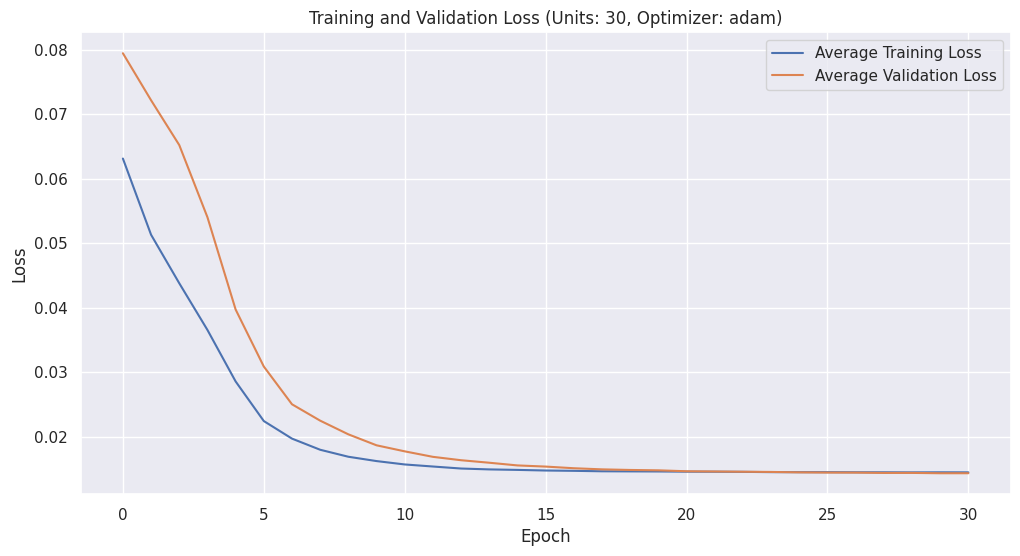

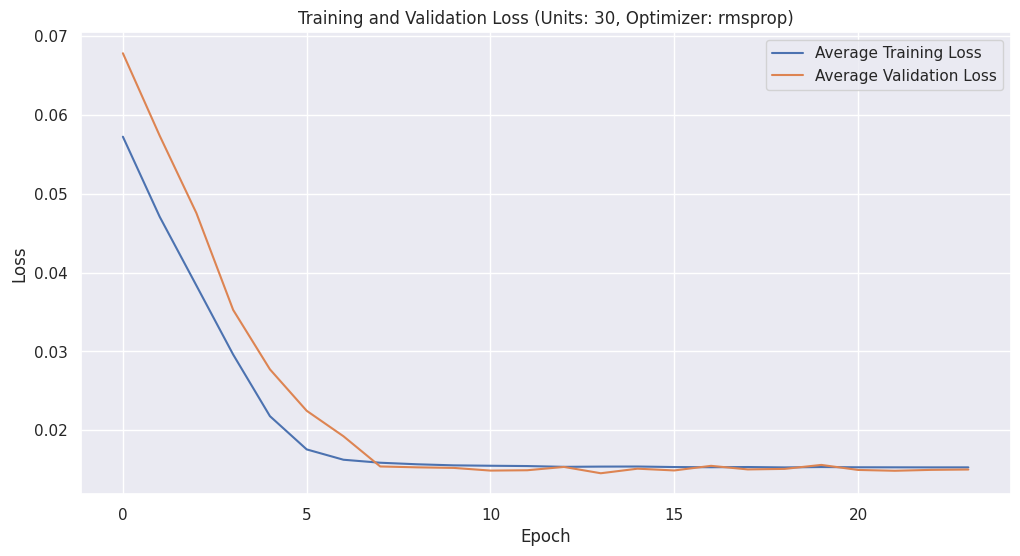

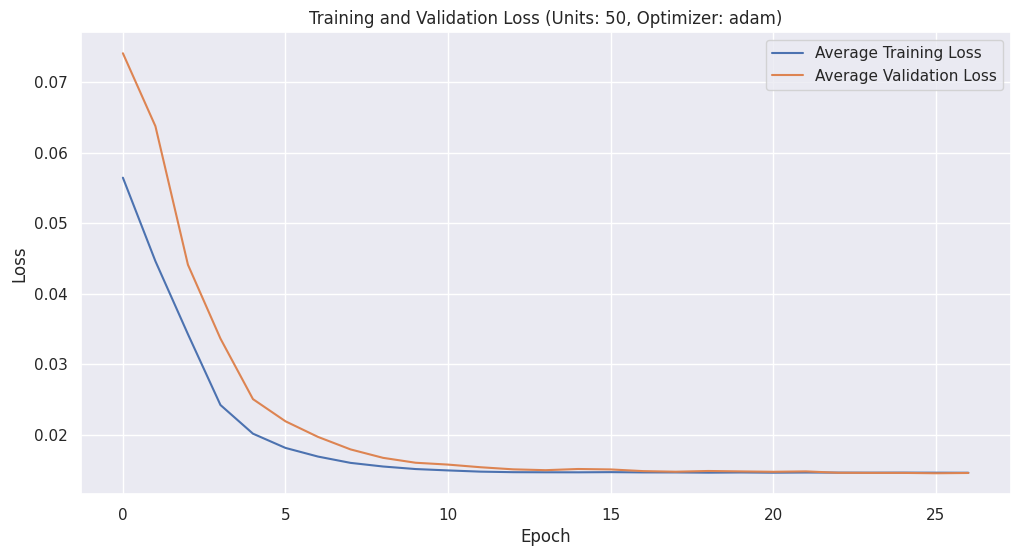

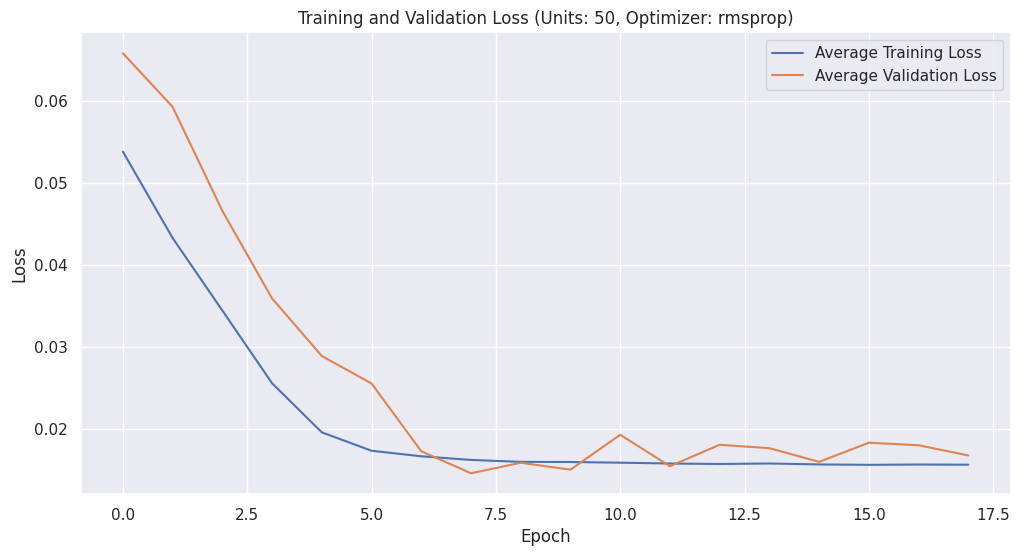

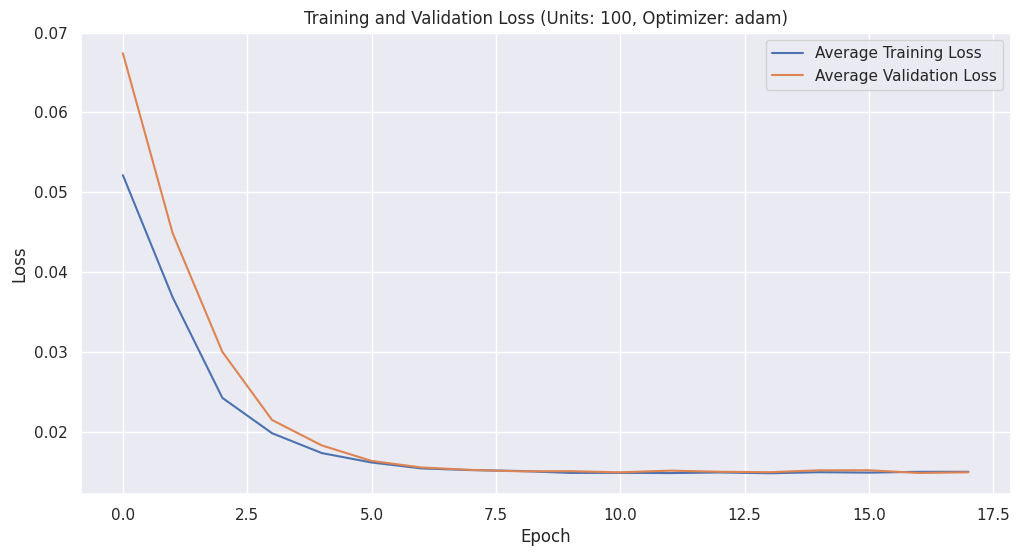

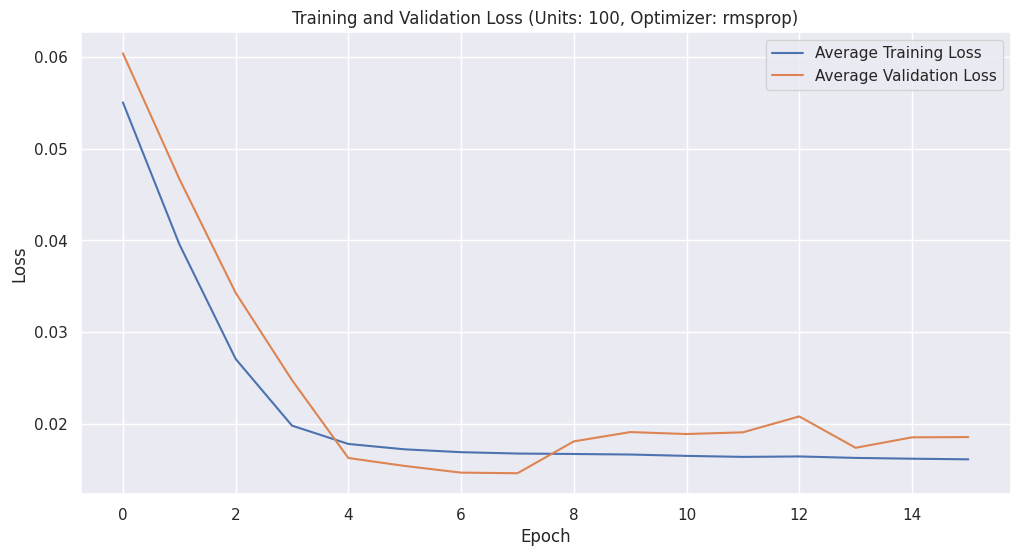

In [22]:
import matplotlib.pyplot as plt

# Function to plot the graph for each hyperparameter combination
def plot_graphs(history_dict, units, opt):
    plt.figure(figsize=(12, 6))

    # Find the maximum number of epochs trained among all seeds
    max_epochs = max([len(h.history['loss']) for h in history_dict[(units, opt)].values()])

    # Function to extend the history arrays to have the same length
    def extend_history(history, max_epochs):
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_trained = len(loss)
        if epochs_trained < max_epochs:
            loss.extend([loss[-1]] * (max_epochs - epochs_trained))
            val_loss.extend([val_loss[-1]] * (max_epochs - epochs_trained))
        return loss, val_loss

    # Extend and then average the histories
    all_losses = [extend_history(h, max_epochs)[0] for h in history_dict[(units, opt)].values()]
    all_val_losses = [extend_history(h, max_epochs)[1] for h in history_dict[(units, opt)].values()]
    avg_train_loss = np.mean(all_losses, axis=0)
    avg_val_loss = np.mean(all_val_losses, axis=0)

    plt.plot(avg_train_loss, label='Average Training Loss')
    plt.plot(avg_val_loss, label='Average Validation Loss')
    plt.title(f'Training and Validation Loss (Units: {units}, Optimizer: {opt})')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()


# Store histories in a nested dictionary
model_histories = {(units, opt): {} for units in lstm_units for opt in optimizers}

for units in lstm_units:
    for opt in optimizers:
        for seed in seeds:
            np.random.seed(seed)
            model = lstm_model((train_X.shape[1], train_X.shape[2]), lstm_units=units, optimizer=opt)
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001)
            history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_split=0.2, verbose=2, shuffle=False, callbacks=[early_stopping])
            model_histories[(units, opt)][seed] = history

# Plotting separate graphs for each hyperparameter combination
for units in lstm_units:
    for opt in optimizers:
        plot_graphs(model_histories, units, opt)


In [23]:
'''
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001)
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_split=0.2, verbose=2, shuffle=False, callbacks=[early_stopping])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

'''

"\n# design network\nmodel = Sequential()\nmodel.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))\nmodel.add(Dense(1))\nmodel.compile(loss='mae', optimizer='adam')\n\n# Configure early stopping\nearly_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001)\n# fit network\nhistory = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_split=0.2, verbose=2, shuffle=False, callbacks=[early_stopping])\n# plot history\npyplot.plot(history.history['loss'], label='train')\npyplot.plot(history.history['val_loss'], label='validation')\npyplot.legend()\npyplot.show()\n\n"

#### Evaluate Model
After the model is fit, we can forecast for the entire test dataset.

We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected pollution numbers.

With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.

In [24]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

1095/1095 [==============================] - 4s 3ms/step


In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))

mae = mean_absolute_error(inv_y, inv_yhat)

r2 = r2_score(inv_y, inv_yhat)

print(f"Test RMSE: {rmse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"R² Score: {r2:.3f}")

print("Inverted Predictions (first 10):")
print(inv_yhat[:10])

# Print the first 10 true values
print("\nTrue Values (first 10):")
print(inv_y[:10])

Test RMSE: 26.371
Mean Absolute Error: 14.037
R² Score: 0.918
Inverted Predictions (first 10):
[40.11933  34.020203 24.027884 24.347864 22.3309   21.213385 19.948467
 18.698416 25.759596 25.396677]

True Values (first 10):
[31. 20. 19. 18. 17. 14. 14. 22. 22. 25.]


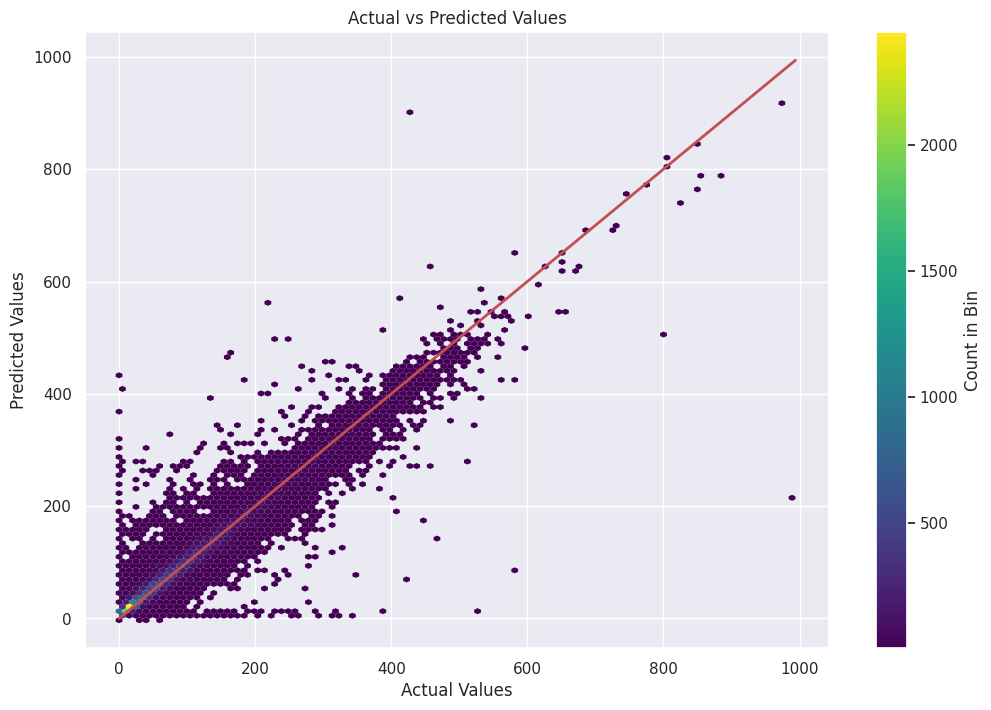

In [26]:
plt.figure(figsize=(12, 8))
plt.hexbin(inv_y, inv_yhat, gridsize=100, cmap='viridis', mincnt=1, edgecolors='none')
plt.colorbar(label='Count in Bin')
plt.plot([inv_y.min(), inv_y.max()], [inv_y.min(), inv_y.max()], 'r-', lw=2)  # Bright red line for perfect predictions
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()
